In [23]:
cd /home/kvothe/repo/dbt-metadata-utils/

/home/kvothe/repo/dbt-metadata-utils


In [24]:

%reload_ext autoreload
%autoreload 2

import json
from collections import deque
from typing import List, Dict, Tuple
from pprint import pprint
from moz_sql_parser import parse
import networkx as nx
from dbt_metadata_utils.column_level import LineagePoint, find_col, slice_ctes, process_lineage_point, draw_graph, draw_multi_graph
from palettable.tableau import TableauLight_10, Tableau_20
import graphviz

In [25]:
model_name = "idf_entities"
with open('notebooks/query.sql', 'r') as f:
    raw_query = f.read()
query = parse(raw_query)

In [26]:
def get_fields(a, b):
    return f"{a.split('.')[-1]}-{b.split('.')[-1]}"

def get_model(name):
    l = name.split('.')
    return '.'.join(l[:-1])

def get_path(col_of_interest, path_id=0):
    nodes: Dict[str, bool] = {}  # dict with bool value which is equal to whether we display the node or not
    edges: List[Tuple[str, str]] = []
        
    # initialise the deque https://docs.python.org/3/library/collections.html#collections.deque
    root = LineagePoint(*find_col(query, col_of_interest), model_name)
    nodes[str(root)] = True
    to_be_parsed = deque([root])

    while len(to_be_parsed):
        lp = to_be_parsed.popleft()
    #     print((str(lp), lp.x, lp.y, lp.display_name))
        
        new_lps: List[LineagePoint] = process_lineage_point(lp, query)
        if new_lps is None or isinstance(lp, list) or isinstance(lp, dict):
            nodes[str(lp)] = False
        else:
            to_be_parsed.extend(new_lps)
            for new_lp in new_lps:
                edges.append((str(new_lp), str(lp)))
                nodes[str(new_lp)] = True
    #return [(n1, n2) for n1, n2 in edges if nodes.get(n1) and nodes.get(n2)]
    return [(get_model(n1), get_model(n2), {'label': get_fields(n1,n2), 'path': path_id}) for n1, n2 in edges if nodes.get(n1) and nodes.get(n2)]

In [27]:
from IPython.display import SVG
cols = ['language_code','score_type','score_id','score_name','per_language_count','per_entity_count','idf']
G = nx.MultiDiGraph()
for i, col in enumerate(cols[:-1]):    
    edges = get_path(col, i)
    G.add_edges_from(edges)


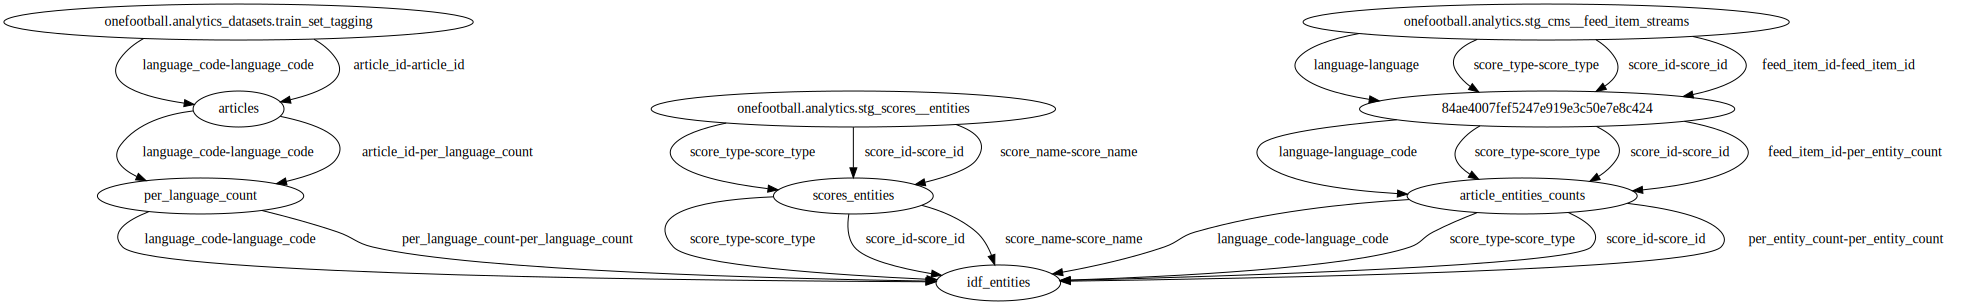

In [28]:
graph = draw_multi_graph(G)
graph.write_png('output.png')
SVG(graph.create(prog='dot', format='svg'))

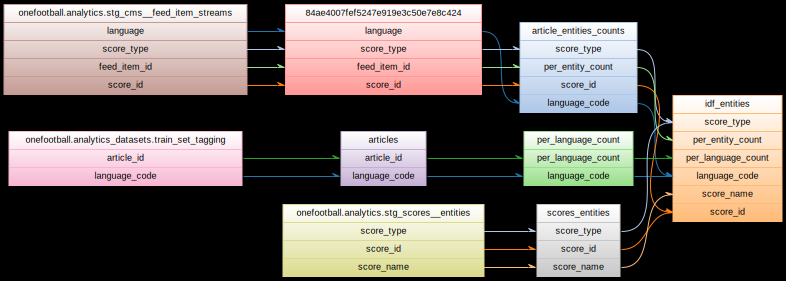

In [29]:
s = graphviz.Digraph(name='column-base lineage', 
                     filename='structs_revisited.gv',
                     graph_attr={'fontname': 'Sans-Serif', 'fontsize':'8'},
                     node_attr={'shape': 'record', 'style': 'filled', 'gradientangle':'90',
                                'fontname': 'Helvetica', 'fontsize':'9'},
                     edge_attr={'arrowhead':'halfopen', 'arrowsize':'0.7'})
s.attr(bgcolor='black')
d = dict()

for i, (a,b,e) in enumerate(G.edges(data=True)):
    x,y = e['label'].split('-')
    path_id = e['path']
    #print(e['label'],x,y)
    if a in d:           
        d[a].add(x)
    else:
        d[a]=set([x])
    if b in d:
        d[b].add(y)
    else:
        d[b]=set([y])
    s.edge(f'{a}:{a}.{x}', f'{b}:{b}.{y}', color=Tableau_20.hex_colors[path_id%20])

for i,(k,v) in enumerate(d.items()):    
    start_color = TableauLight_10.hex_colors[i%20]
    color = f'{start_color}:white'
    s.node(k, k+'|'+'|'.join([f'<{k}.{field}> {field}' for field in v]), color=color)

s.graph_attr['rankdir'] = 'LR'
s